In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm

plt.rcParams.update({
    "axes.titlesize": 14,    # Tamaño del título
    "axes.labelsize": fontsize,    # Tamaño de xlabel y ylabel
})

# Point cloud without noise

## Visualizing the poing cloud that we want to approximate

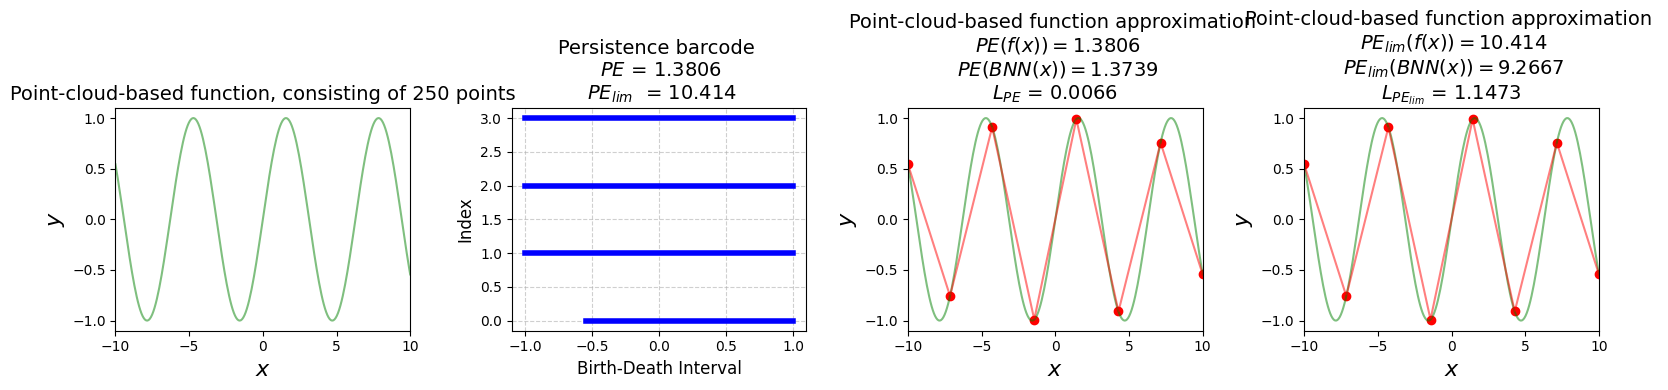

In [2]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_optimize=6
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize+2), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricSigmaNetworkTf(points)

y_aprox = model(x_train)

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]
entropyAprox=persistent_entropy_tf(dgmAprox)
entropyAproxLim=persistent_entropy_lim_tf(dgmAprox)

loss = PersistentEntropyLossTF()
lossLim = PersistentEntropyLossLimTF()
error = loss(dgmRef,dgmAprox)
errorLim = lossLim(dgmRef,dgmAprox)

lim="lim"
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyRef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefLim.numpy().item(),4)}")
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[2].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[2].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Point-cloud-based function approximation \n $PE(f(x)) = {np.round(entropyRef.numpy().item(),4)}$\n $PE(BNN(x)) = {np.round(entropyAprox.numpy().item(),4)}$ \n' + '$L_{PE}$' + f' = {round(error.numpy().item(),4)}')
axs[3].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[3].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[3].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$y$')
axs[3].set_xlim((domain[0],domain[1]))
axs[3].set_title(f'Point-cloud-based function approximation \n $PE_{{lim}}(f(x)) = {np.round(entropyRefLim.numpy().item(),4)}$ \n $PE_{{lim}}(BNN(x)) = {np.round(entropyAproxLim.numpy().item(),4)}$ \n' + '$L_{PE_{lim}}$' + f' = {round(errorLim.numpy().item(),4)}')
fig.tight_layout()
plt.savefig('figures/WithoutNoiseUnknownFunction.png', dpi=300, bbox_inches='tight')
plt.show()

An illustrative example of calculating persistence entropy and persistence entropy with modification because we want to find the points to approximate an Point-cloud-based function well so its important to get a similar persistent entropy and also the lengths of the bars.

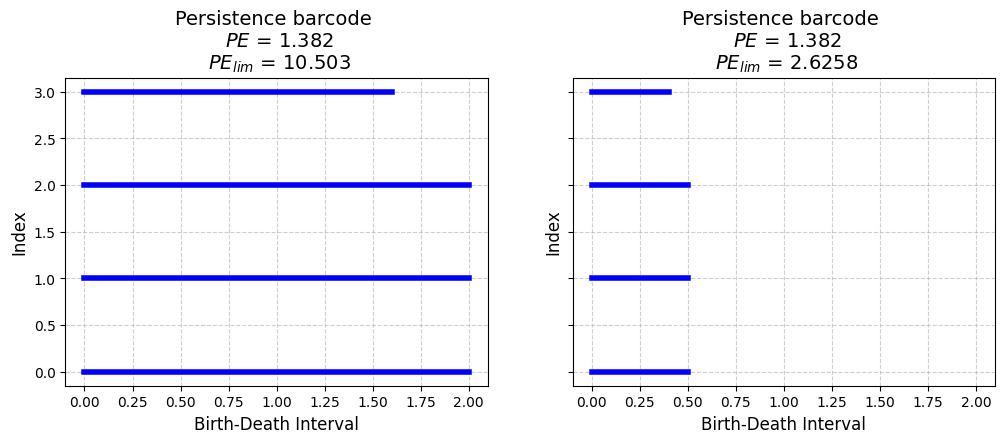

In [3]:
dgmA = np.array([[0,2],[0,2],[0,2],[0,1.6]])
dgmB = np.array([[0,0.5],[0,0.5],[0,0.5],[0,0.4]])
entropyA = persistent_entropy_tf(dgmA)
entropyLimA = persistent_entropy_lim_tf(dgmA)
entropyB = persistent_entropy_tf(dgmB)
entropyLimB = persistent_entropy_lim_tf(dgmB)

fig, axs = plt.subplots(1, 2, figsize=(12, 4),sharex=True,sharey=True)
plot_persistent_barcode(dgmA,ax=axs[0])
axs[0].set_title(axs[0].get_title() + f" \n $PE$ = {round(entropyA.numpy().item(),4)}" + "\n $PE_{lim}$ " + f"= {round(entropyLimA.numpy().item(),4)}")
plot_persistent_barcode(dgmB,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyB.numpy().item(),4)}" + "\n $PE_{lim}$ " + f"= {round(entropyLimB.numpy().item(),4)}")
plt.show()

As we have seen in the Compare_PELoss.ipynb the loss function using $PE_{lim}$ is better, so from now on we will use it for the calculation of the loss function

## MSE loss

 20%|██        | 1/5 [00:00<00:01,  2.27it/s]

tf.Tensor(0.10943242, shape=(), dtype=float32)


 40%|████      | 2/5 [00:00<00:01,  2.73it/s]

tf.Tensor(0.10785095, shape=(), dtype=float32)


 60%|██████    | 3/5 [00:01<00:00,  3.00it/s]

tf.Tensor(0.10628659, shape=(), dtype=float32)


 80%|████████  | 4/5 [00:01<00:00,  2.62it/s]

tf.Tensor(0.10476172, shape=(), dtype=float32)


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

tf.Tensor(0.10328269, shape=(), dtype=float32)


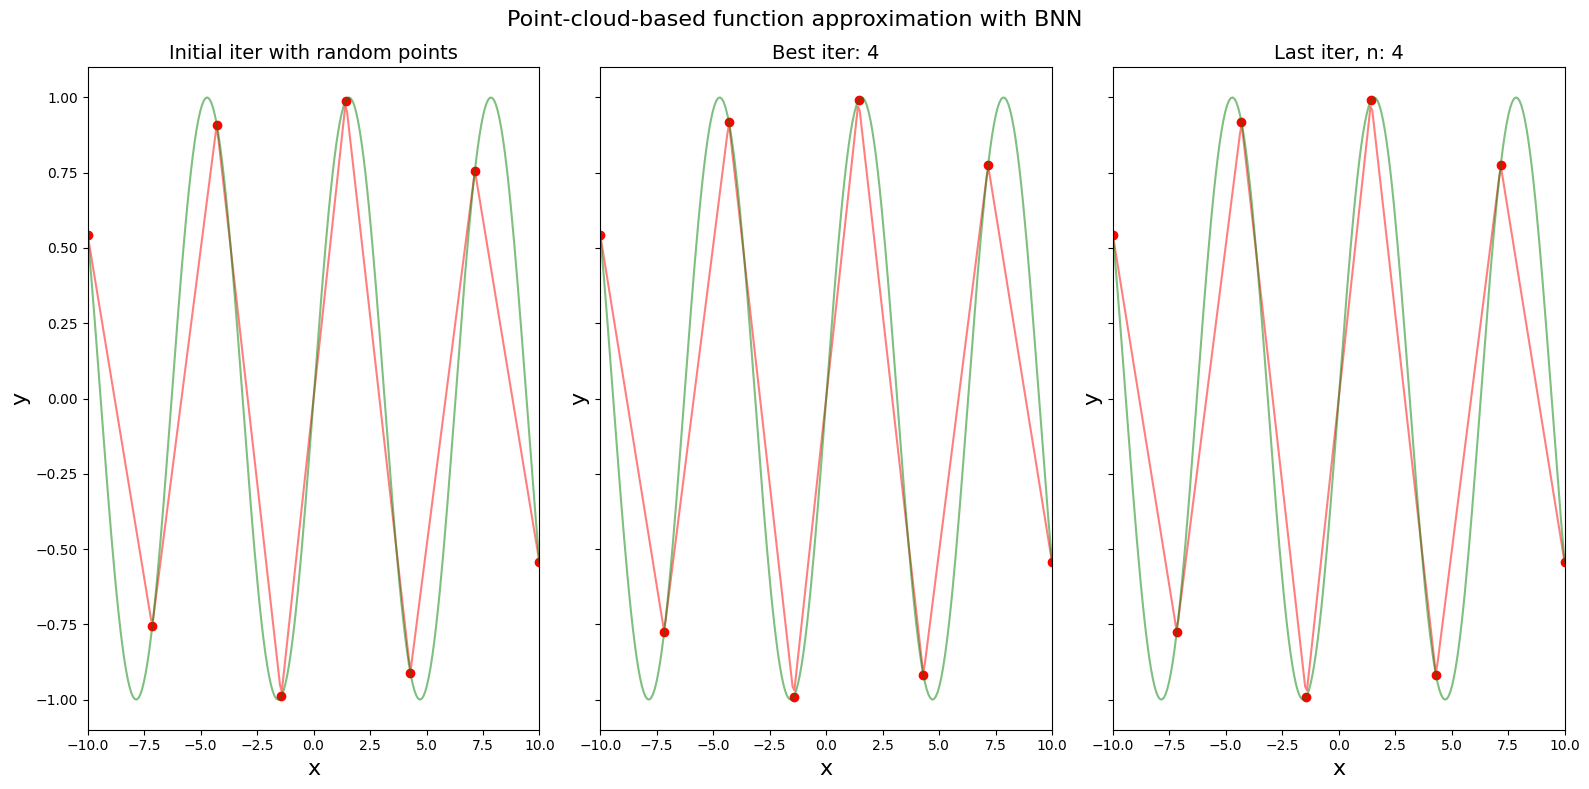

In [2]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_optimize=6
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

best_mse = float('inf')  
num_iter = 5  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        mseActual = tf.keras.losses.MSE(y_train,y_aprox)
        print(mseActual)
    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    lossFunction = PersistentEntropyLossLimTF()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasMSE_wnoise = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_MSELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

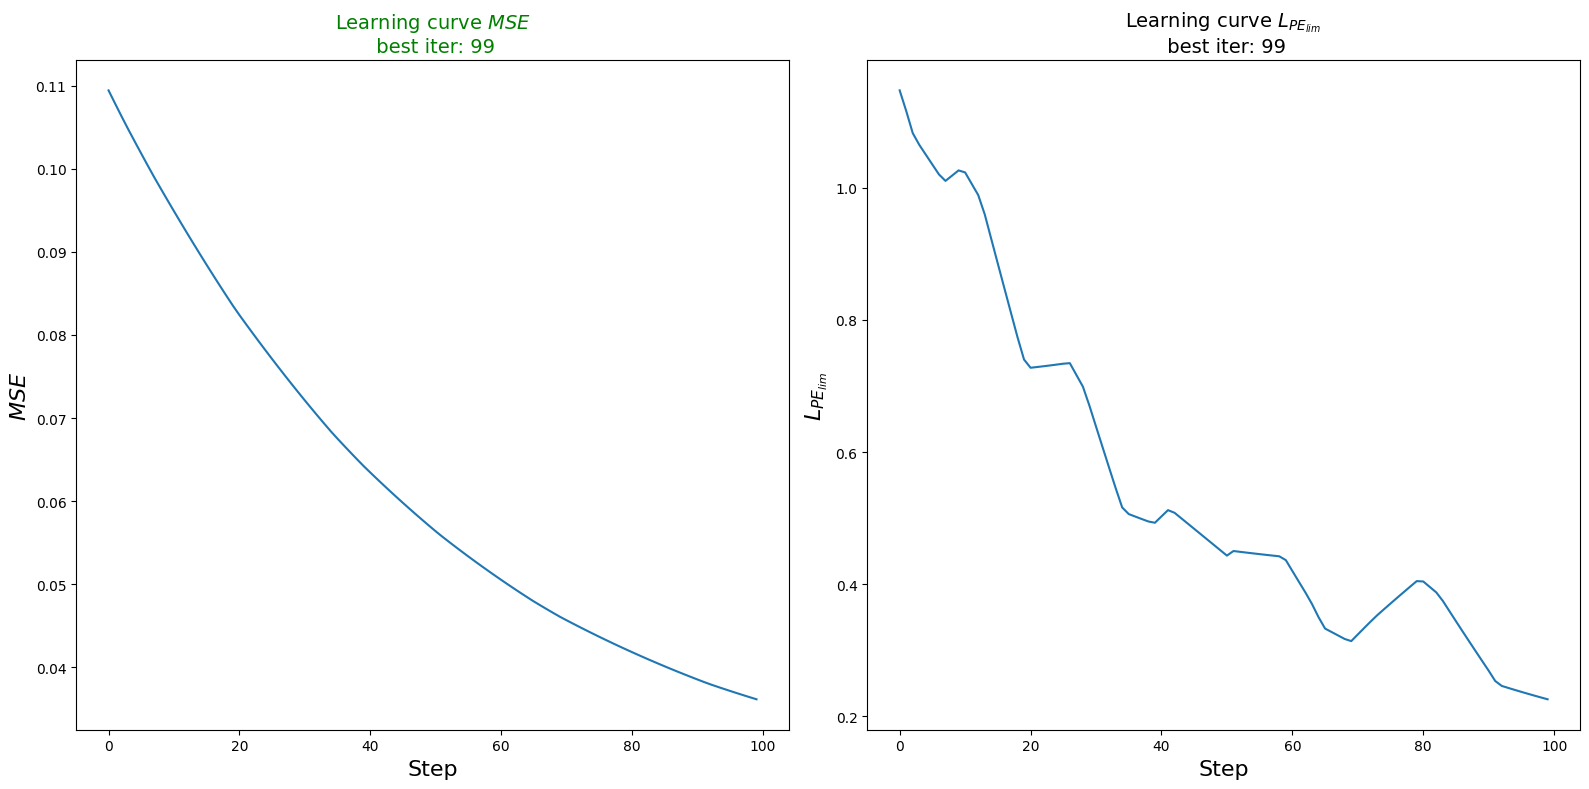

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

What about initializing points very bad and not with equidistant points in this case, because in that way are good point of start

100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


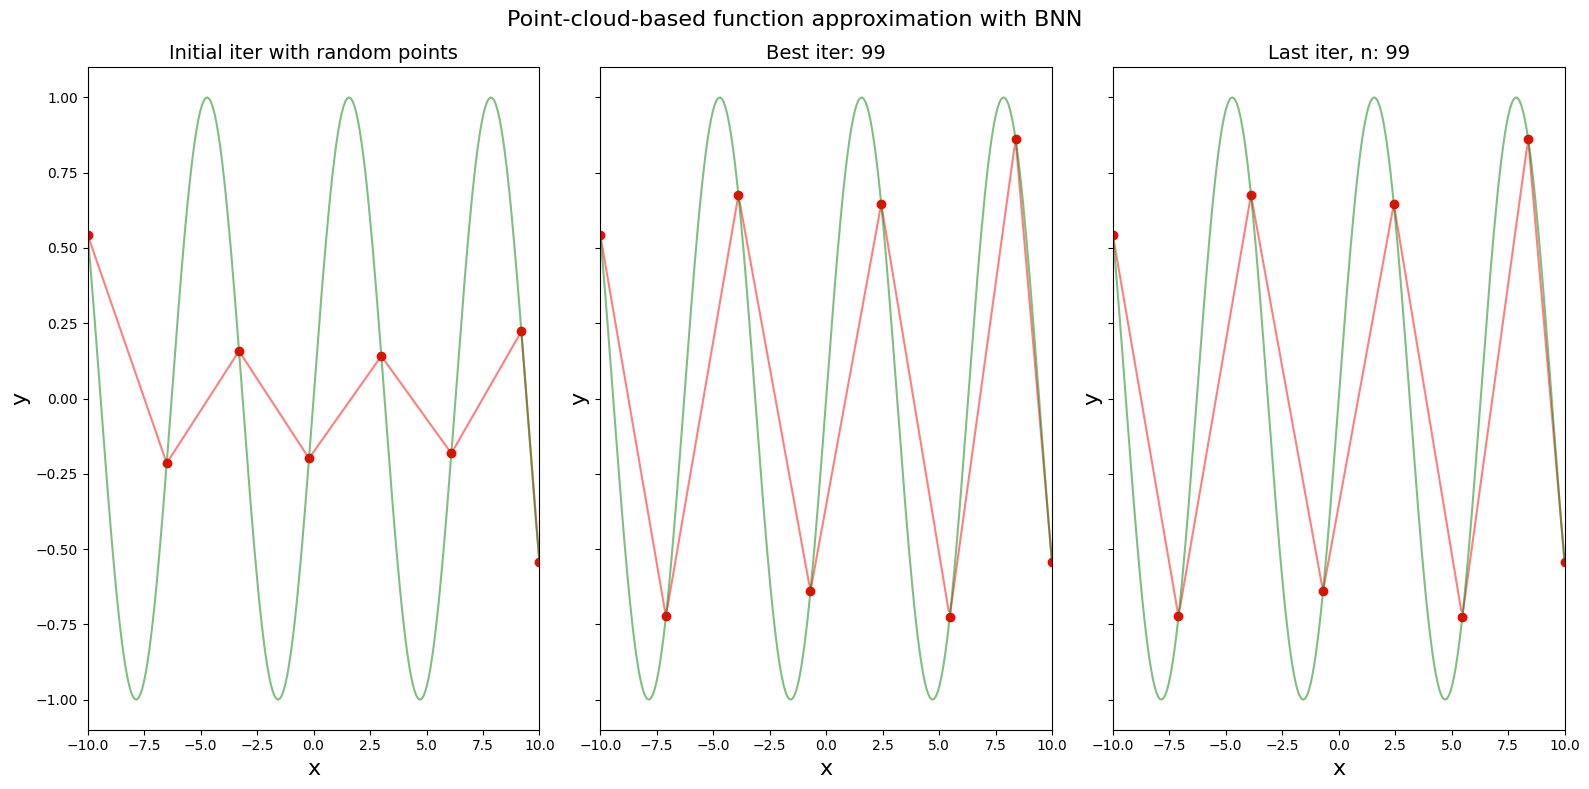

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_optimize=6
x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10],trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    lossFunction = PersistentEntropyLossLimTF()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasMSE_wnoise_init = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_MSELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

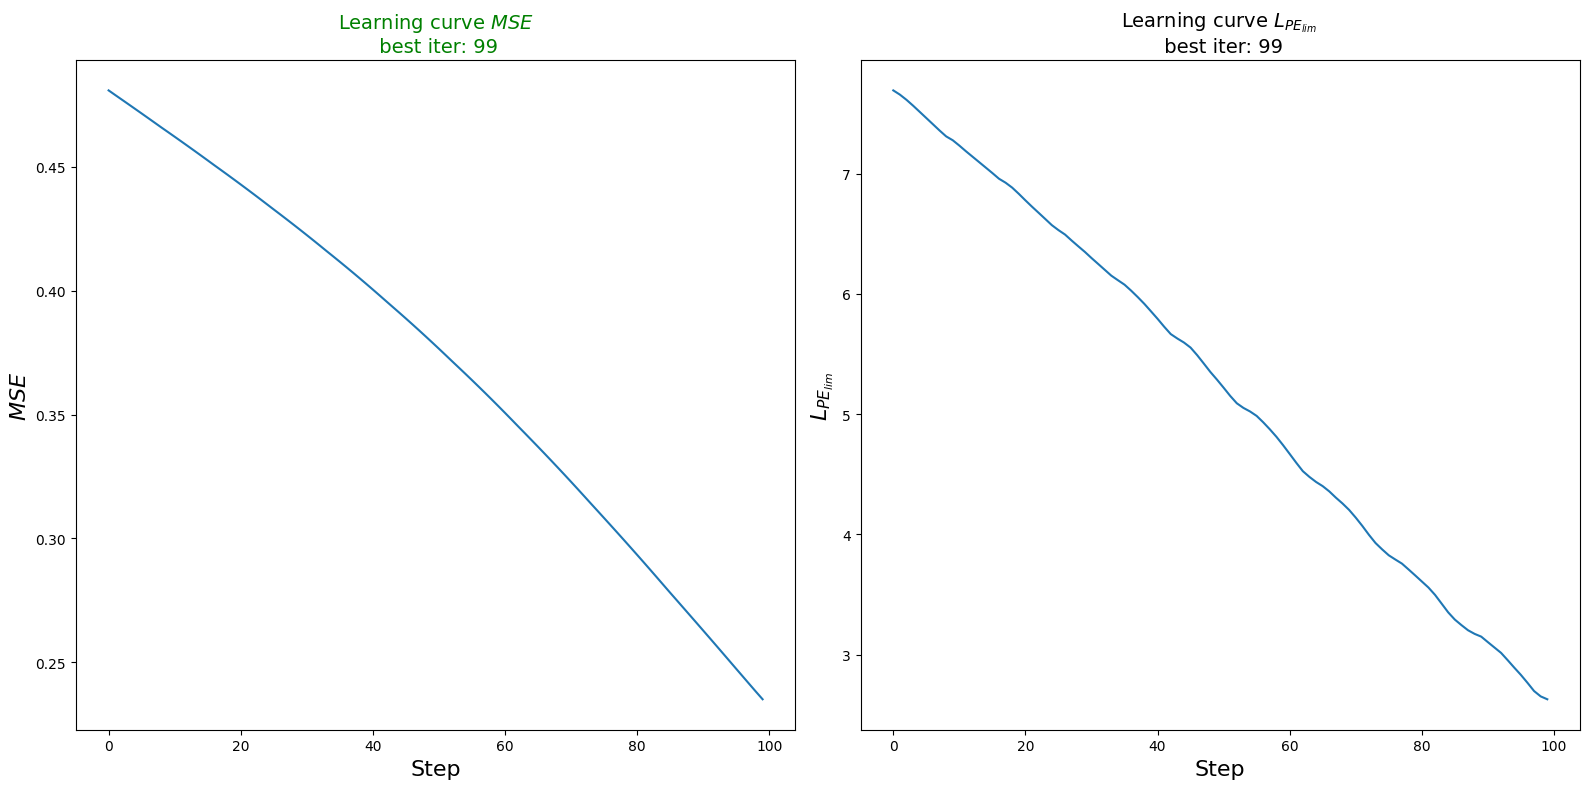

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## $L_{PE_{lim}}$ loss

100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


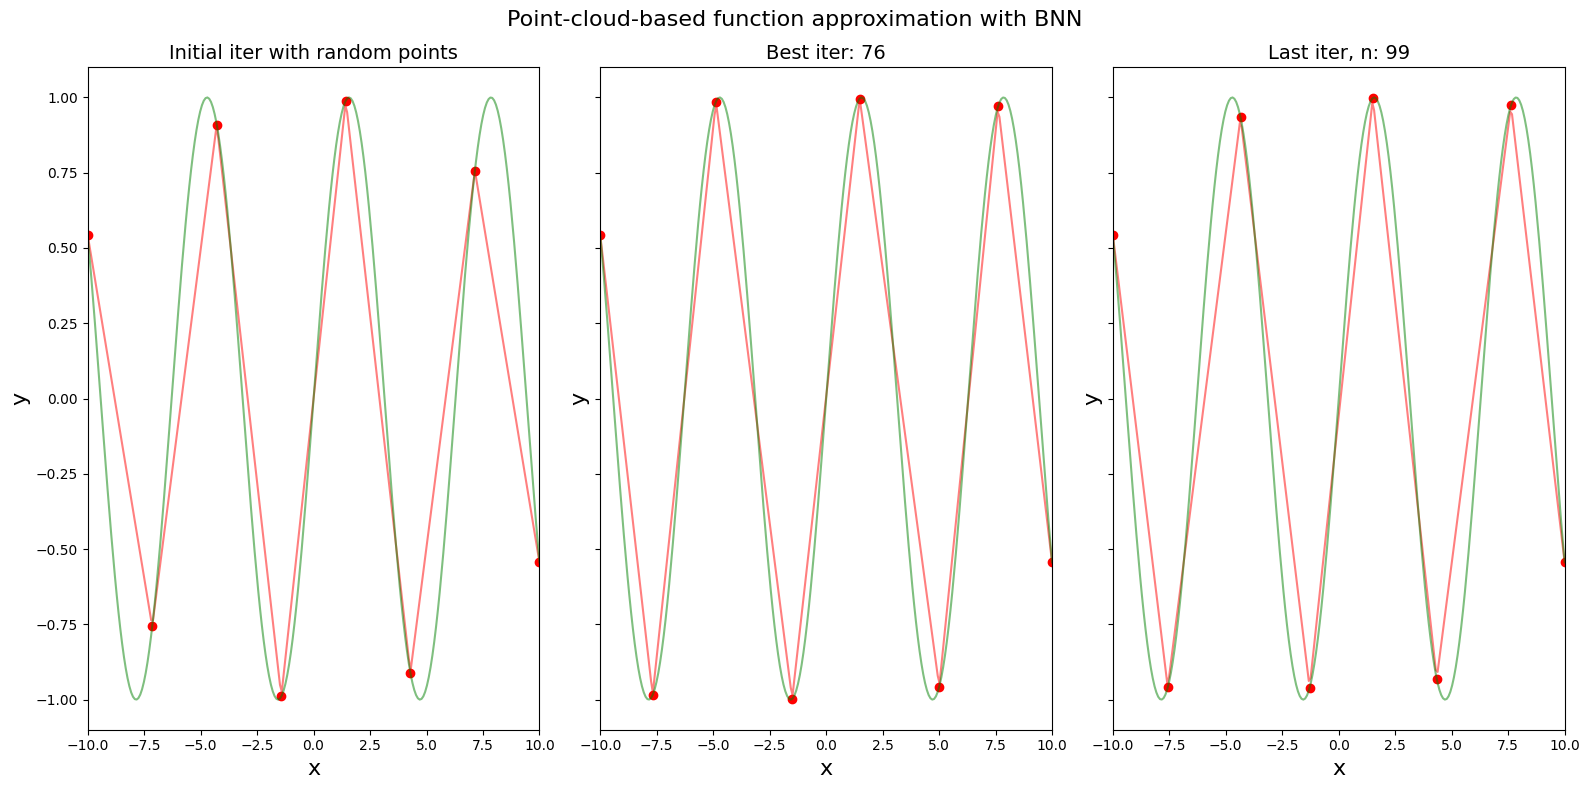

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_optimize=6
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_PELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

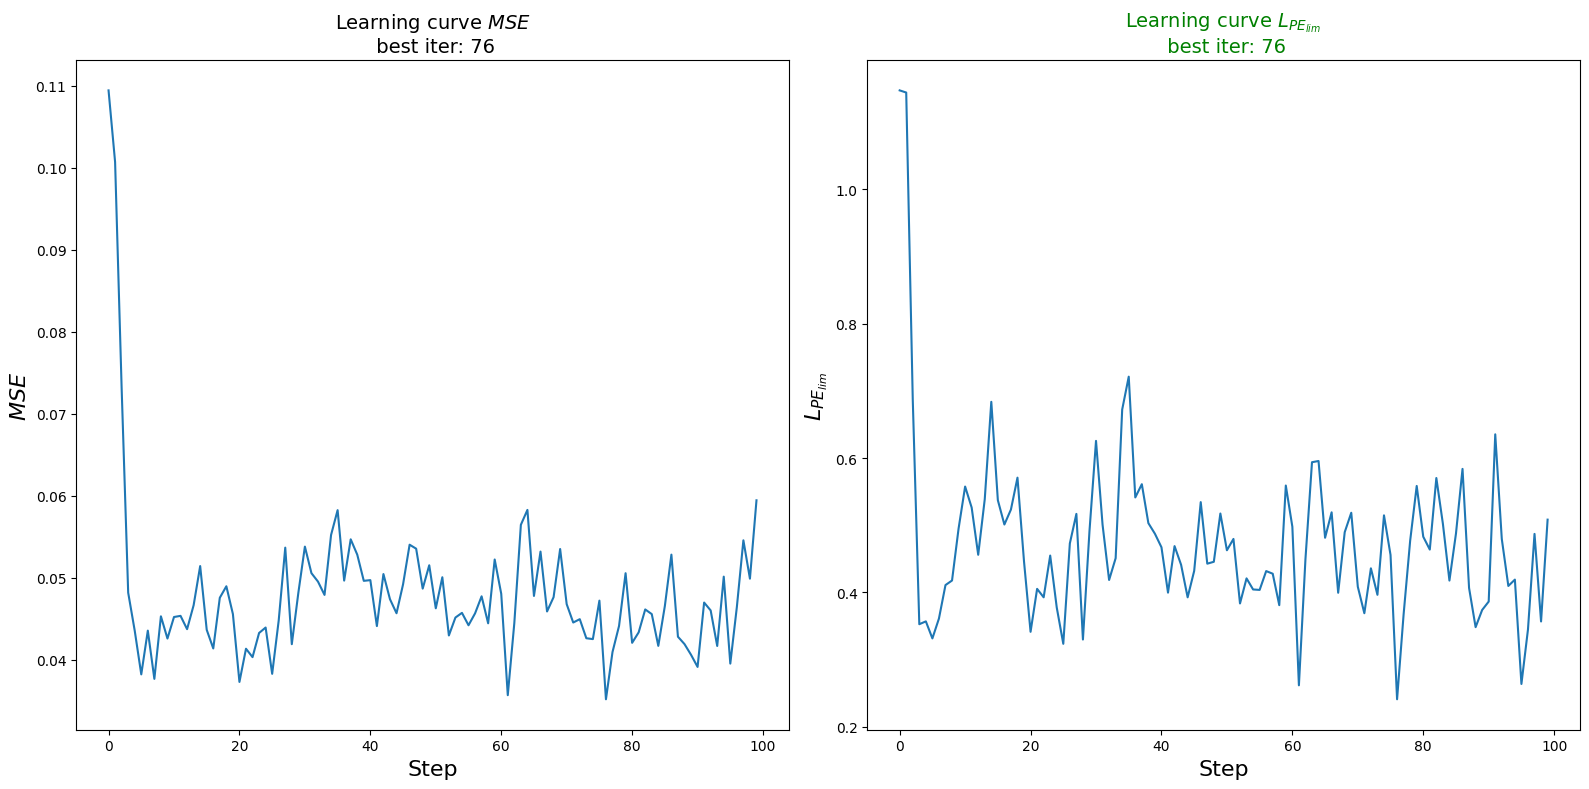

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

What about initializing points very bad and not with equidistant points in this case, because in that way are a good point of start.

100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


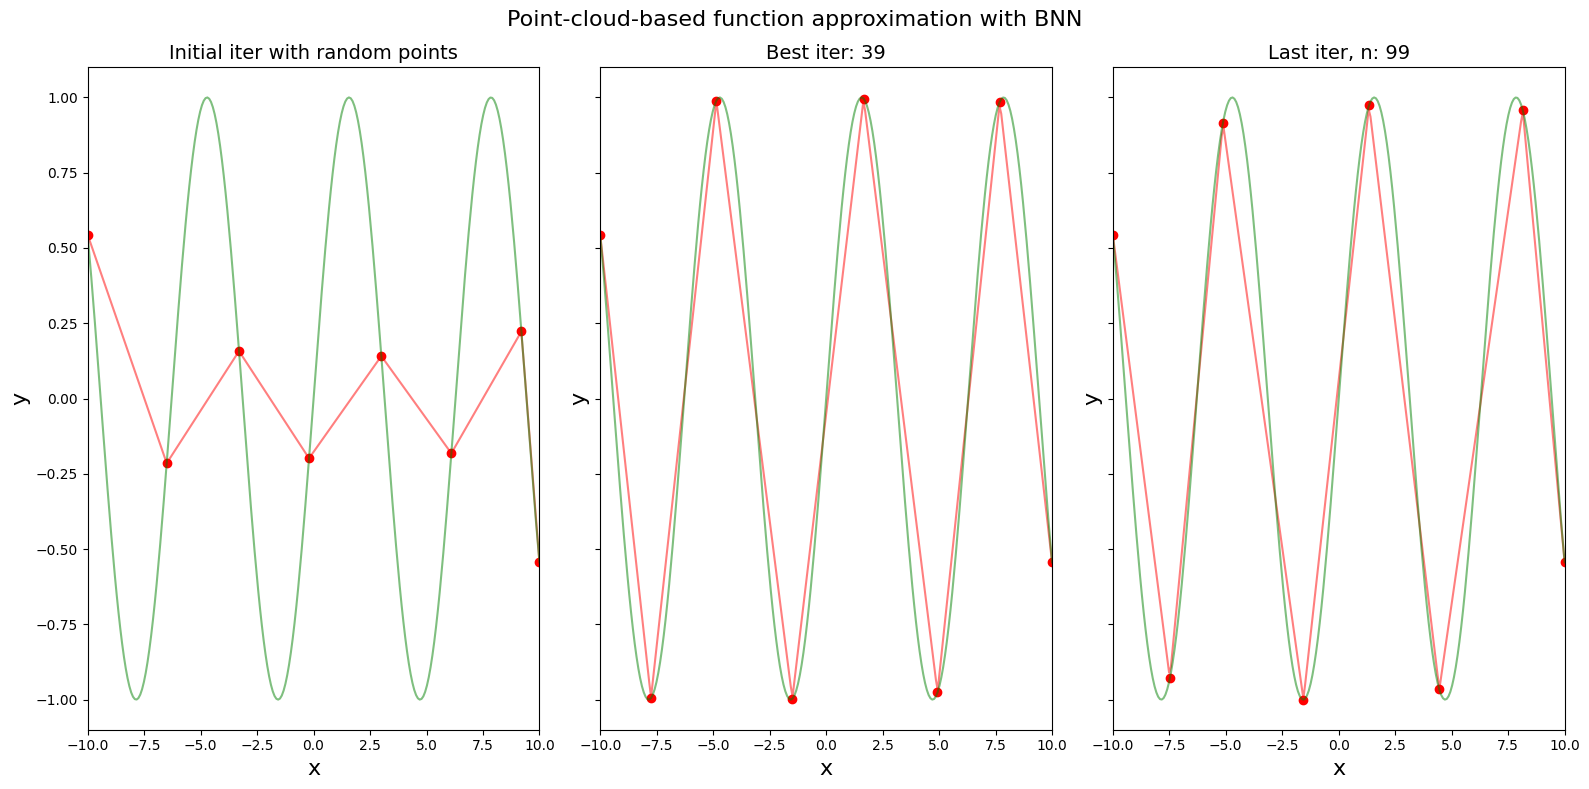

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_optimize=6
x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise_init  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_PELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

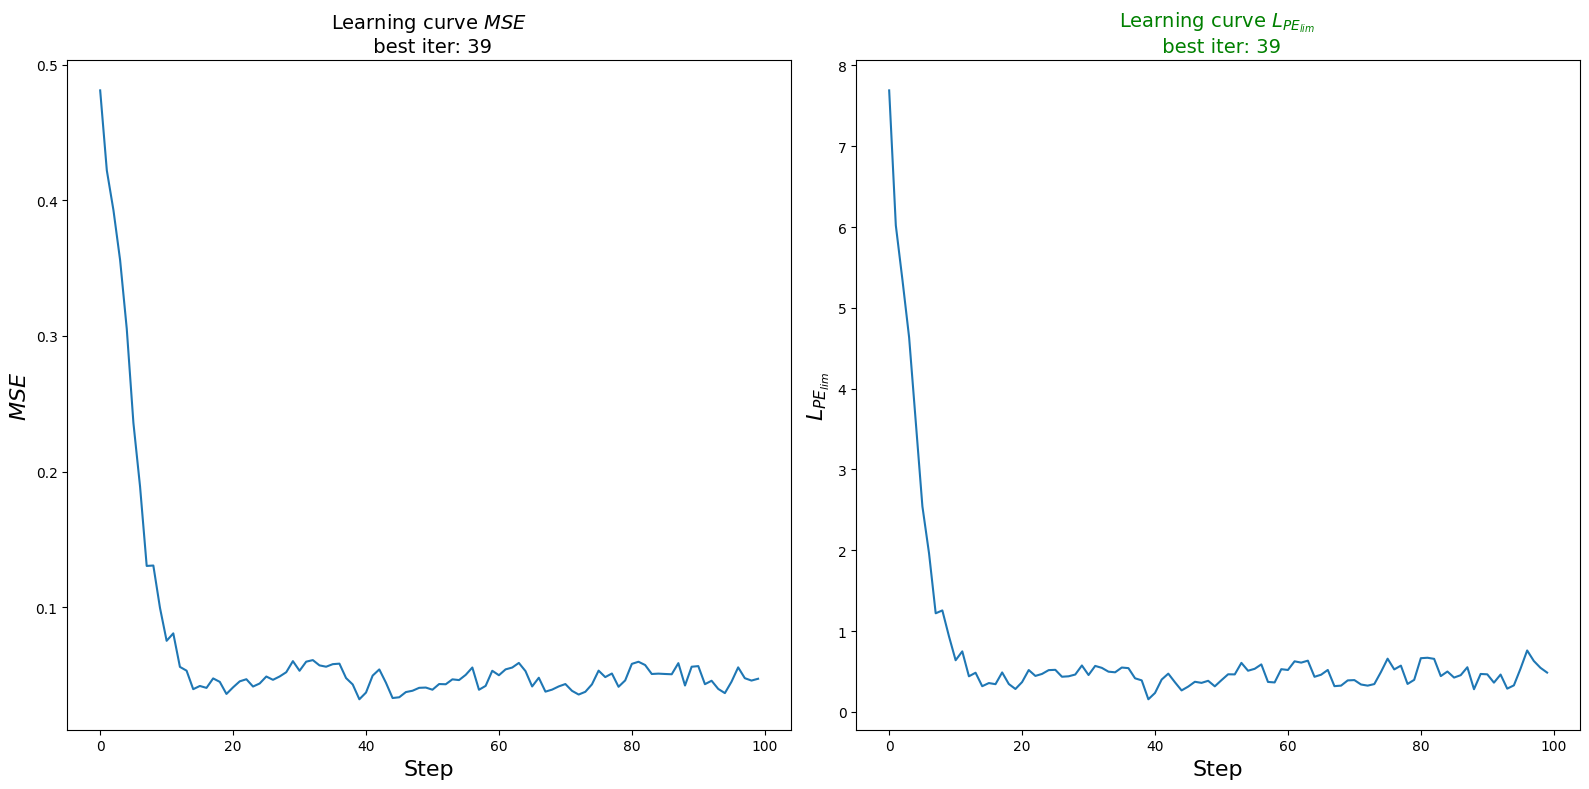

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## Comparing learning curves MSE and $L_{PE_{lim}}$

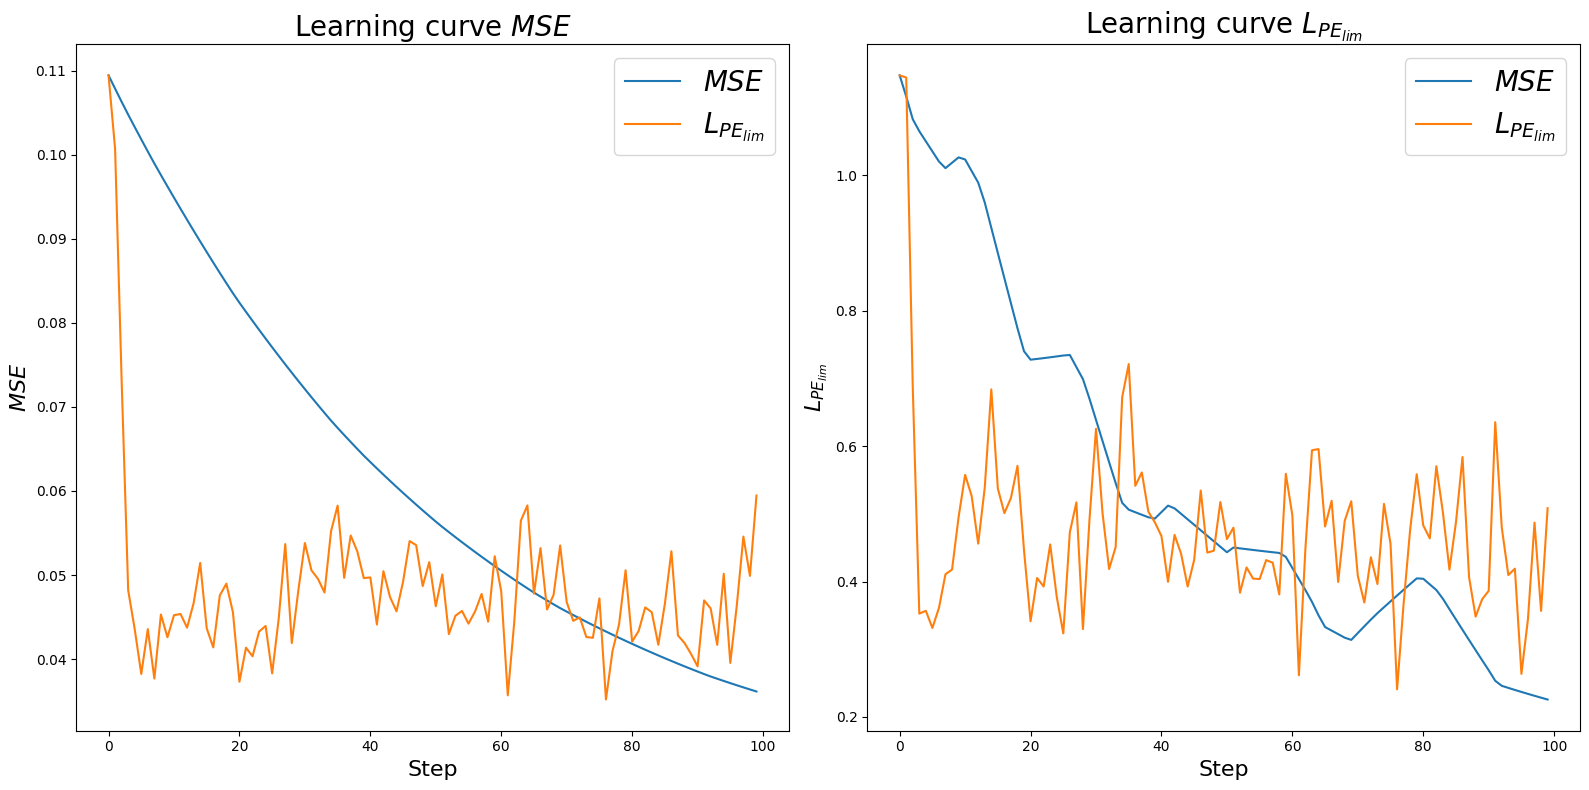

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{PE_{lim}}$"]
for i, metric in enumerate([metricasMSE_wnoise, metricasPE_wnoise]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout() 
plt.savefig('figures/LearningCurves_WithoutNoiseUnknownFunction_GoodInit.png', dpi=300, bbox_inches='tight')
plt.show()

Starting with worst points initialization

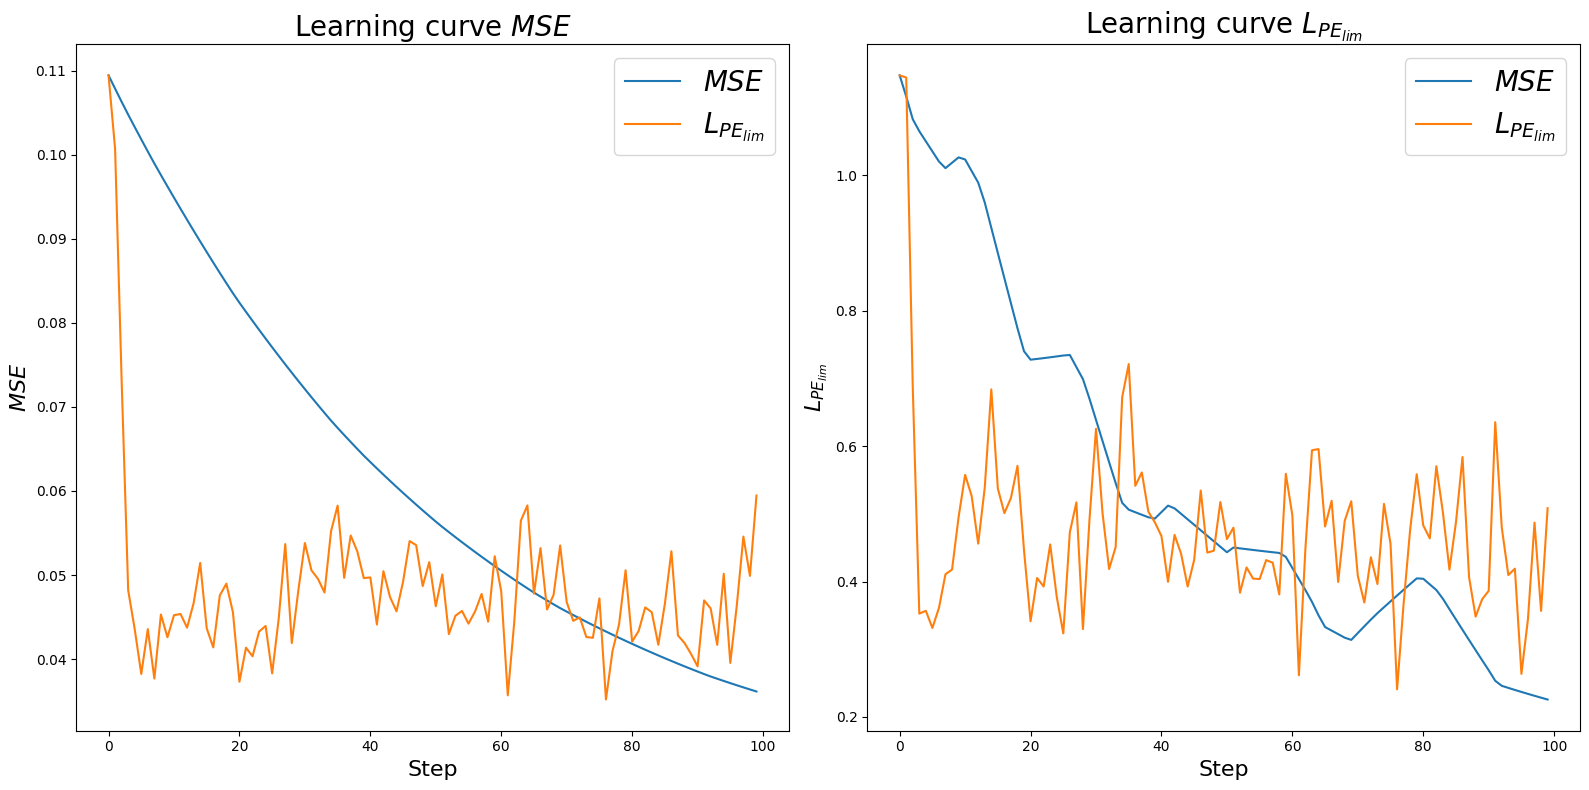

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{PE_{lim}}$"]
for i, metric in enumerate([metricasMSE_wnoise, metricasPE_wnoise]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_WithoutNoiseUnknownFunction_BadInit.png', dpi=300, bbox_inches='tight')
plt.show()

In modern deep learning, Mean Squared Error (MSE) is a widely used loss function, primarily due to its simplicity and effectiveness in minimizing numerical discrepancies. PEowever, MSE alone does not always guarantee a well-structured representation of the underlying data, as it focuses solely on minimizing pointwise differences without considering the global structure. This is where Persistent Entropy (PE) comes into play, either as an alternative loss function or as a regularization term when combined with MSE (MSE + PE). PE leverages topological properties to enhance the learning process, providing a more structured approach to optimization.

From the presented learning curves, we observe that models trained with $L_{PE_{lim}}$ exhibit a sharper initial improvement in performance compared to those using only $MSE$. This suggests that $L_{PE_{lim}}$ provides more informative gradients in the early training stages, enabling the model to quickly capture essential structural features in the data. PEowever, in the later stages of training, models trained solely with $L_{PE_{lim}}$ show slightly worse performance than those optimized with $MSE$. This could be due to the fact that $L_{PE_{lim}}$ enforces a stronger structural constraint, which may sometimes conflict with pure numerical optimization.

On the other hand, when combining $MSE$ with $L_{PE_{lim}}$ ($MSE$ + $L_{PE_{lim}}$), we observe a balanced behavior: the model benefits from the rapid early convergence of $L_{PE_{lim}}$ while maintaining the precision of $MSE$ in the later stages. This combination suggests that $L_{PE_{lim}}$ acts as a regularizer, improving the stability and structure of learned representations without significantly sacrificing accuracy.

# Same point cloud with noise

## Visualizing the poing cloud that we want to approximate

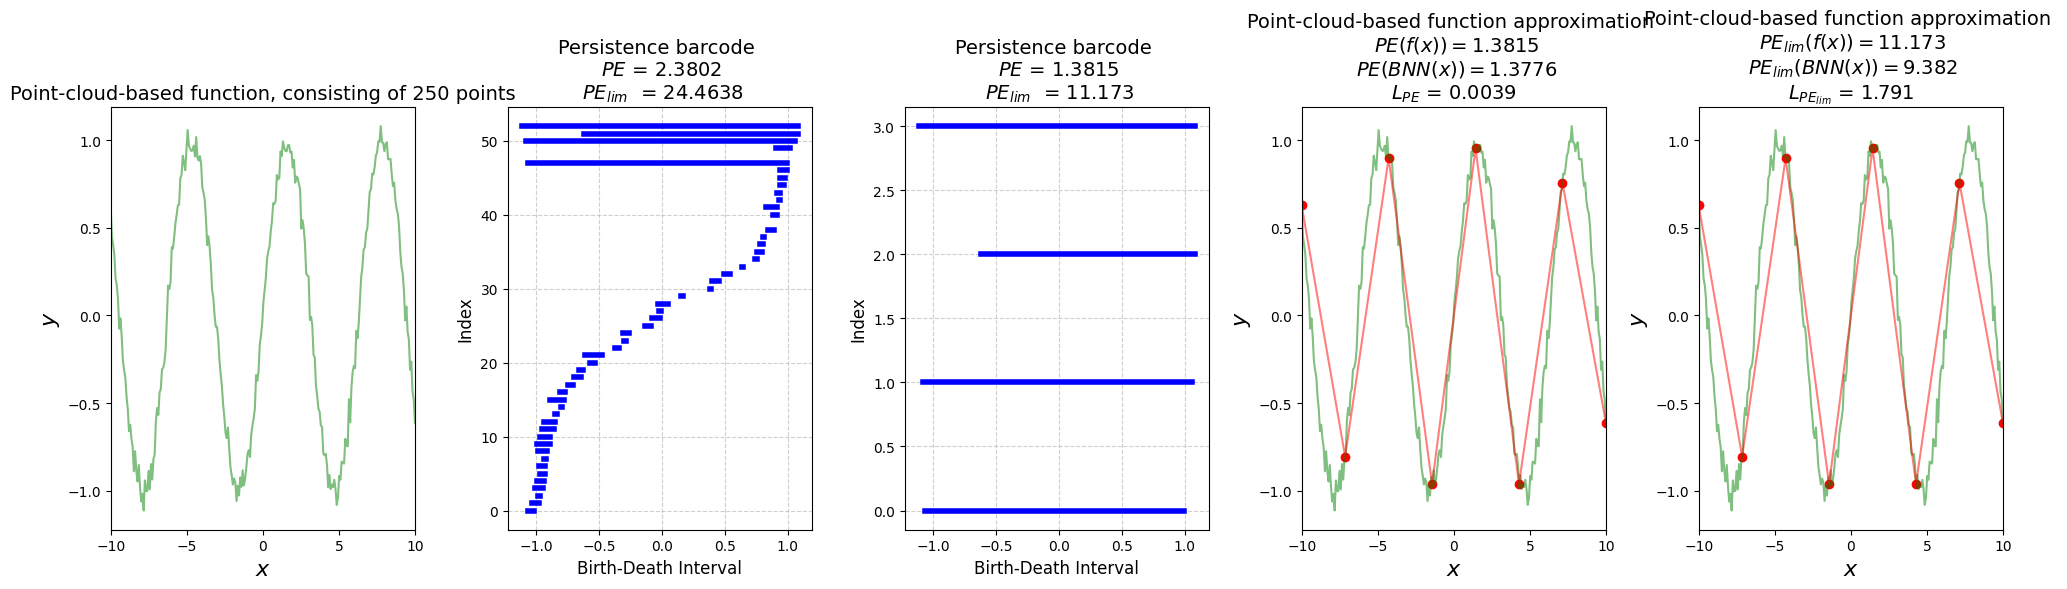

In [3]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=6
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize+2), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricSigmaNetworkTf(points)

y_aprox = model(x_train)

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]

entropyAprox=persistent_entropy_tf(dgmAprox)
entropyAproxLim=persistent_entropy_lim_tf(dgmAprox)

loss = PersistentEntropyLossTF()
lossLim = PersistentEntropyLossLimTF()
error = loss(dgmRefFilt,dgmAprox)
errorLim = lossLim(dgmRefFilt,dgmAprox)

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyRef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefLim.numpy().item(),4)}")
plot_persistent_barcode(dgmRefFilt,ax=axs[2])
axs[2].set_title(axs[2].get_title() + f" \n $PE$ = {round(entropyRefFilt.numpy().item(),4)}")
axs[2].set_title(axs[2].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefFiltLim.numpy().item(),4)}")
axs[3].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[3].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[3].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$y$')
axs[3].set_xlim((domain[0],domain[1]))
axs[3].set_title(f'Point-cloud-based function approximation \n $PE(f(x)) = {np.round(entropyRefFilt.numpy().item(),4)}$\n $PE(BNN(x)) = {np.round(entropyAprox.numpy().item(),4)}$ \n' + '$L_{PE}$' + f' = {round(error.numpy().item(),4)}')
axs[4].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[4].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[4].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[4].set_xlabel('$x$')
axs[4].set_ylabel('$y$')
axs[4].set_xlim((domain[0],domain[1]))
axs[4].set_title(f'Point-cloud-based function approximation \n $PE_{{lim}}(f(x)) = {np.round(entropyRefFiltLim.numpy().item(),4)}$ \n $PE_{{lim}}(BNN(x)) = {np.round(entropyAproxLim.numpy().item(),4)}$ \n' + '$L_{PE_{lim}}$' + f' = {round(errorLim.numpy().item(),4)}')
fig.tight_layout()
plt.show()

## MSE loss

100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


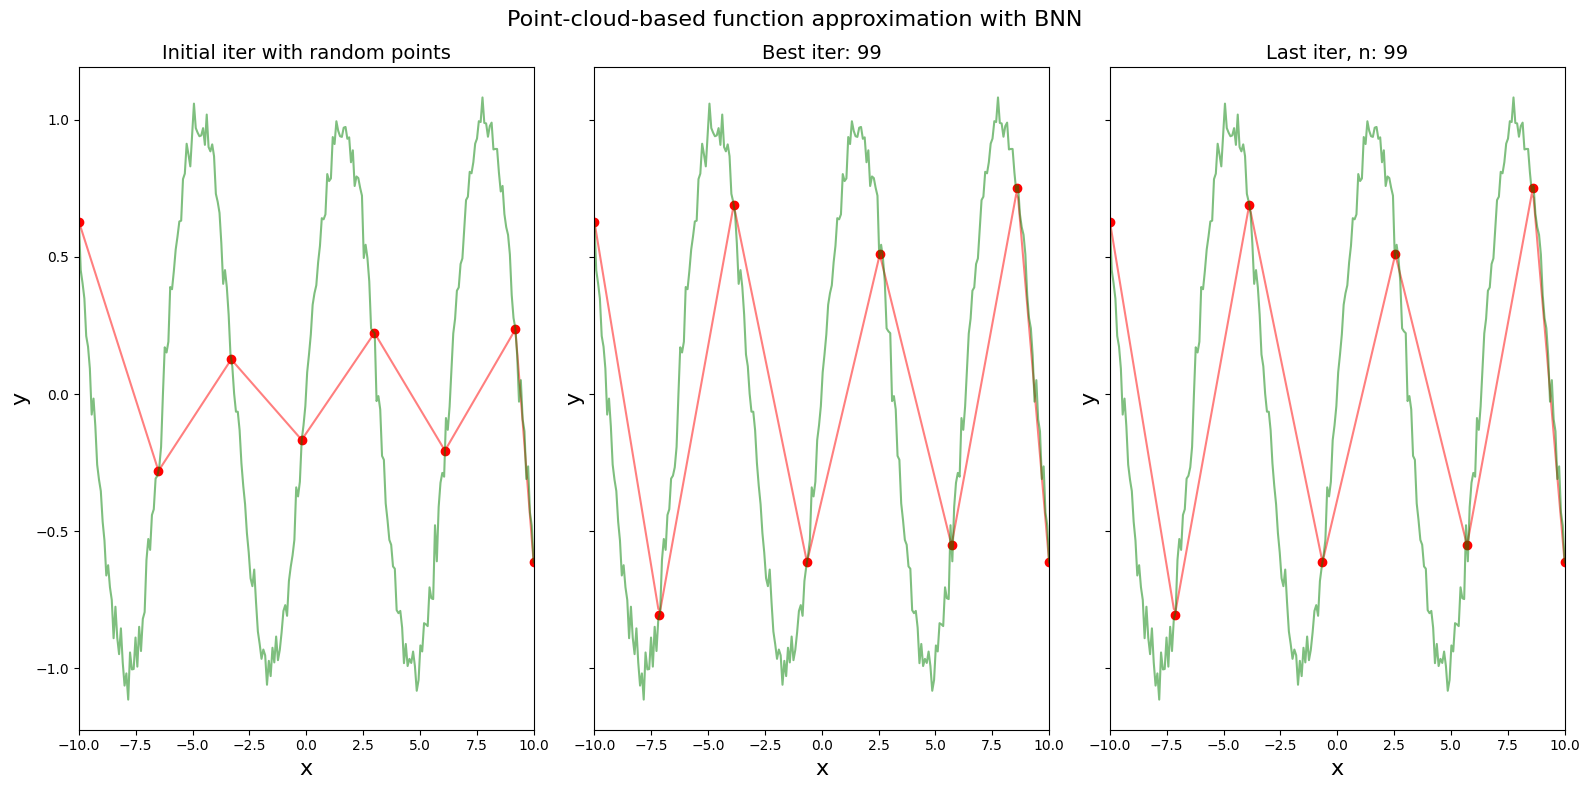

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=6
x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10],trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    lossFunction = PersistentEntropyLossLimTF()
    entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasMSE_noise_init = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_MSELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

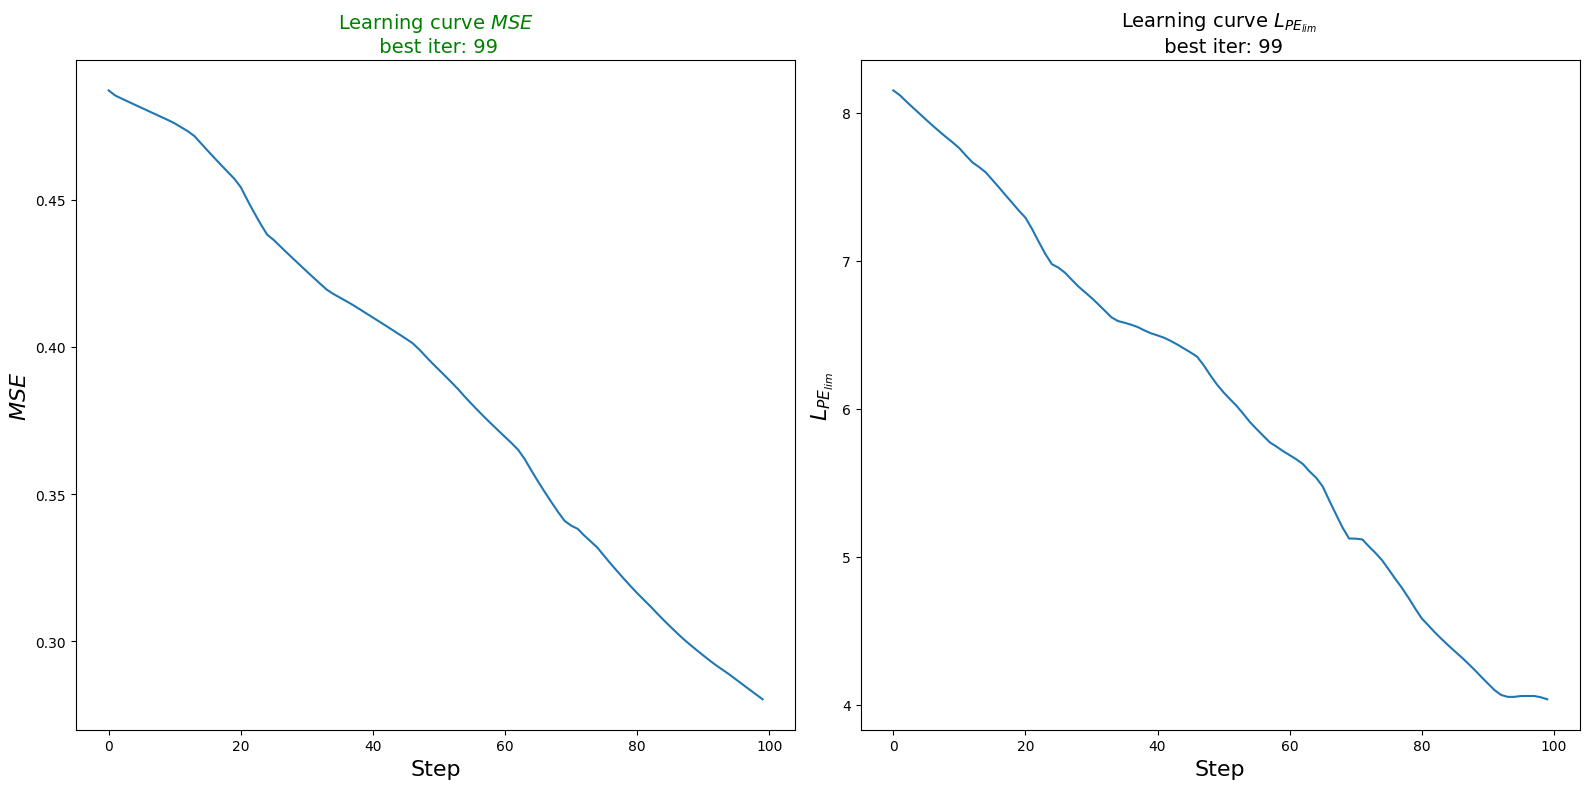

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## $L_{PE_{lim}}$ loss

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


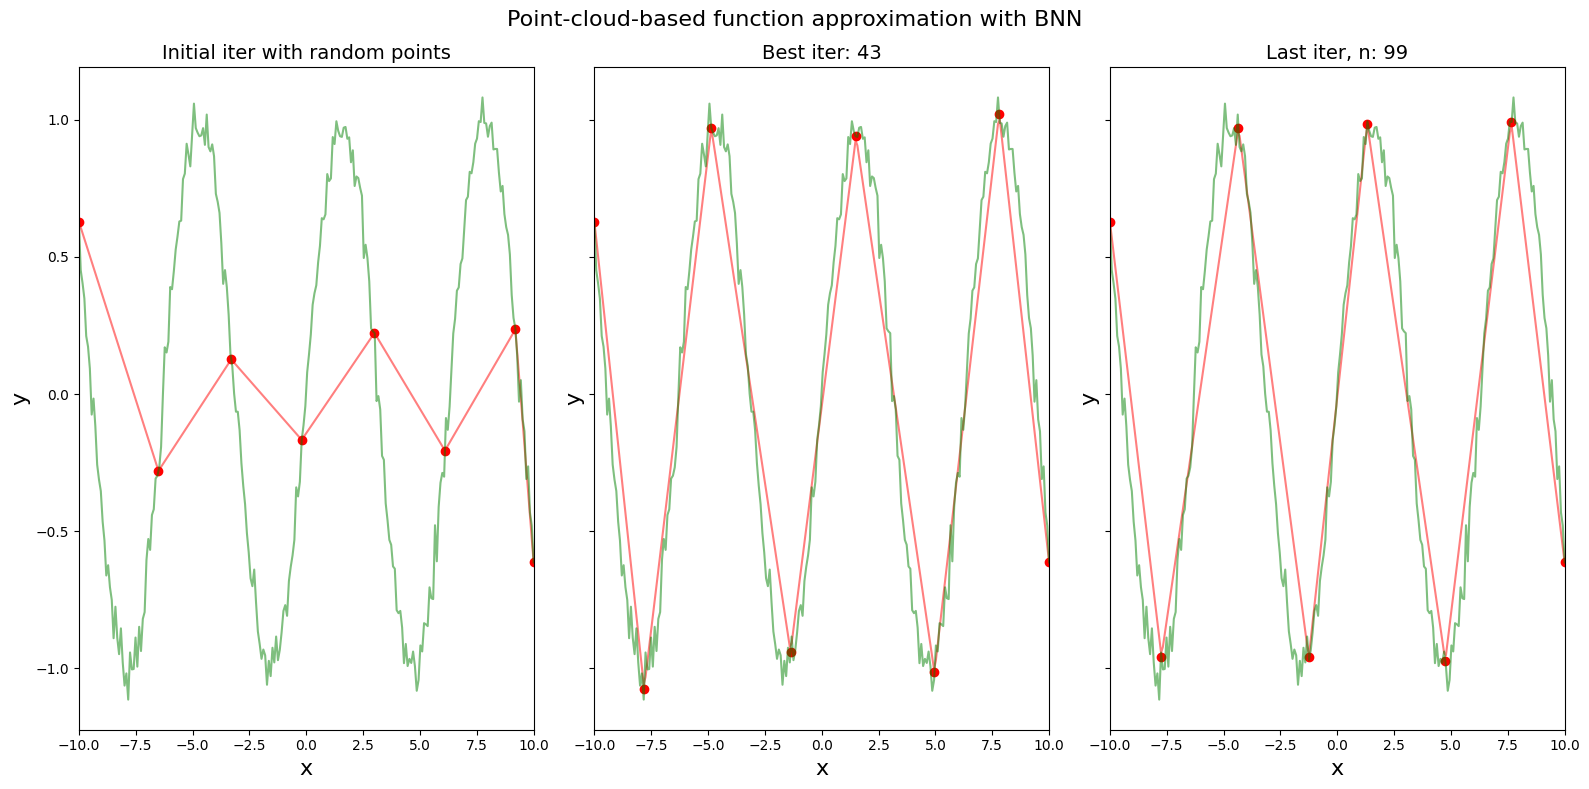

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=6
x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss.numpy().item() < min_diff_entropy:
        min_diff_entropy = entropyLoss.numpy().item()
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_noise_init  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_PELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

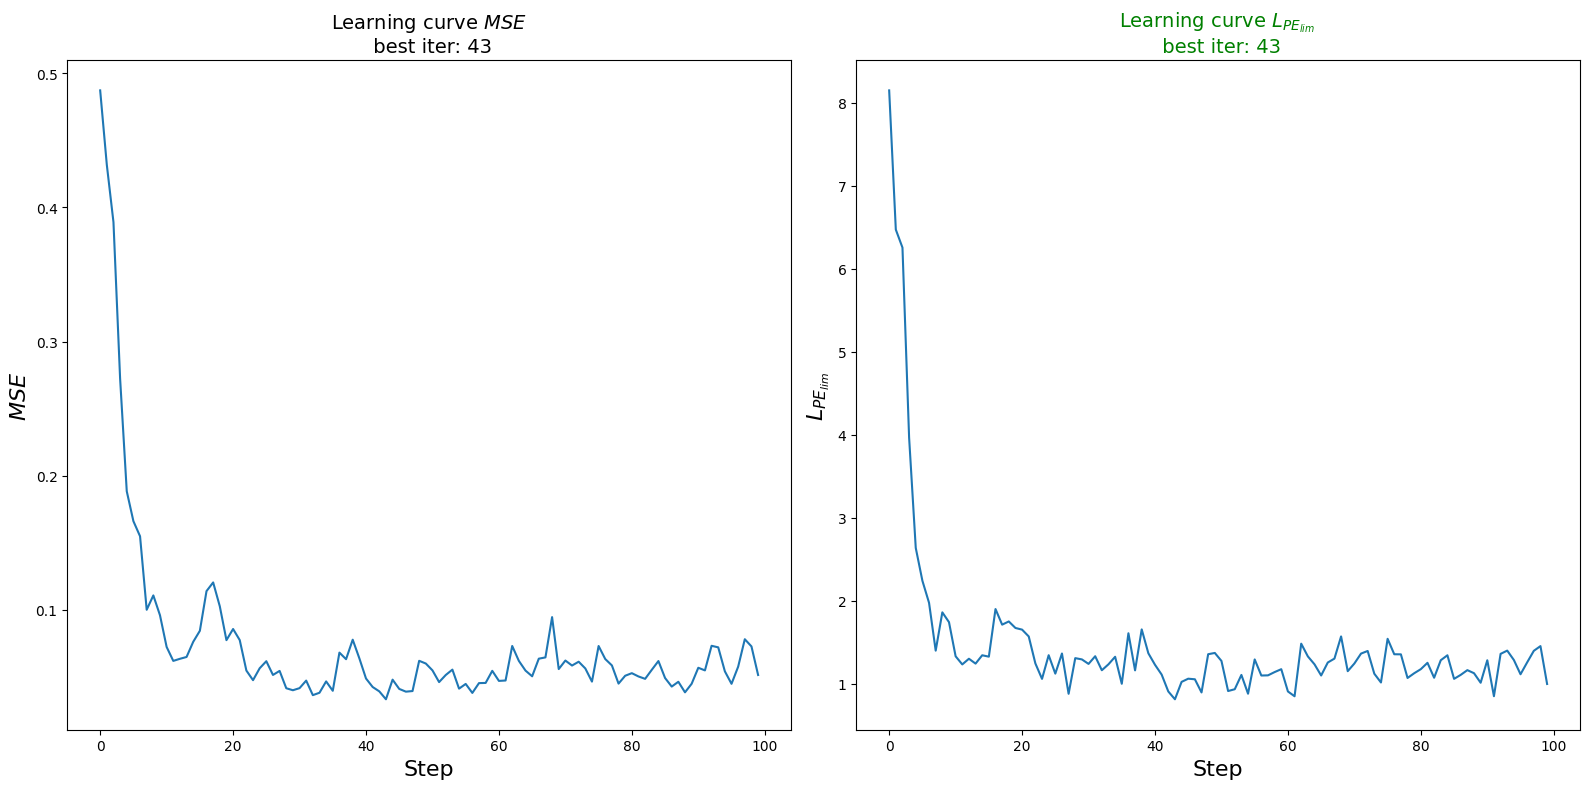

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## Comparing learning curves MSE and $L_{PE_{lim}}$

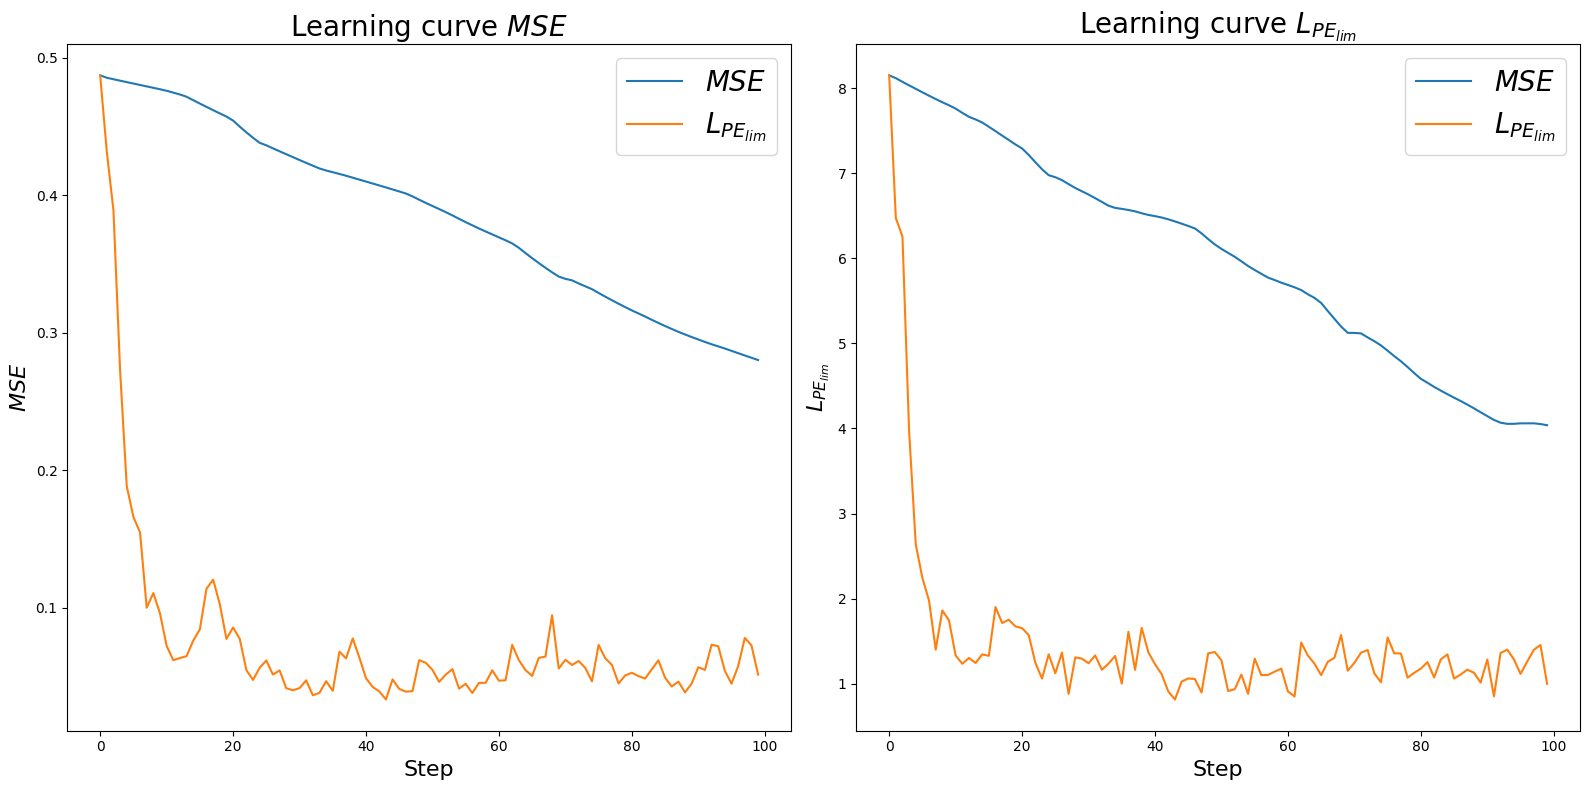

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{PE_{lim}}$"]
for i, metric in enumerate([metricasMSE_noise_init, metricasPE_noise_init]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_WithNoiseUnknownFunction_BadInit.png', dpi=300, bbox_inches='tight')
plt.show()

# Random point cloud

## Visualizing the poing cloud that we want to approximate

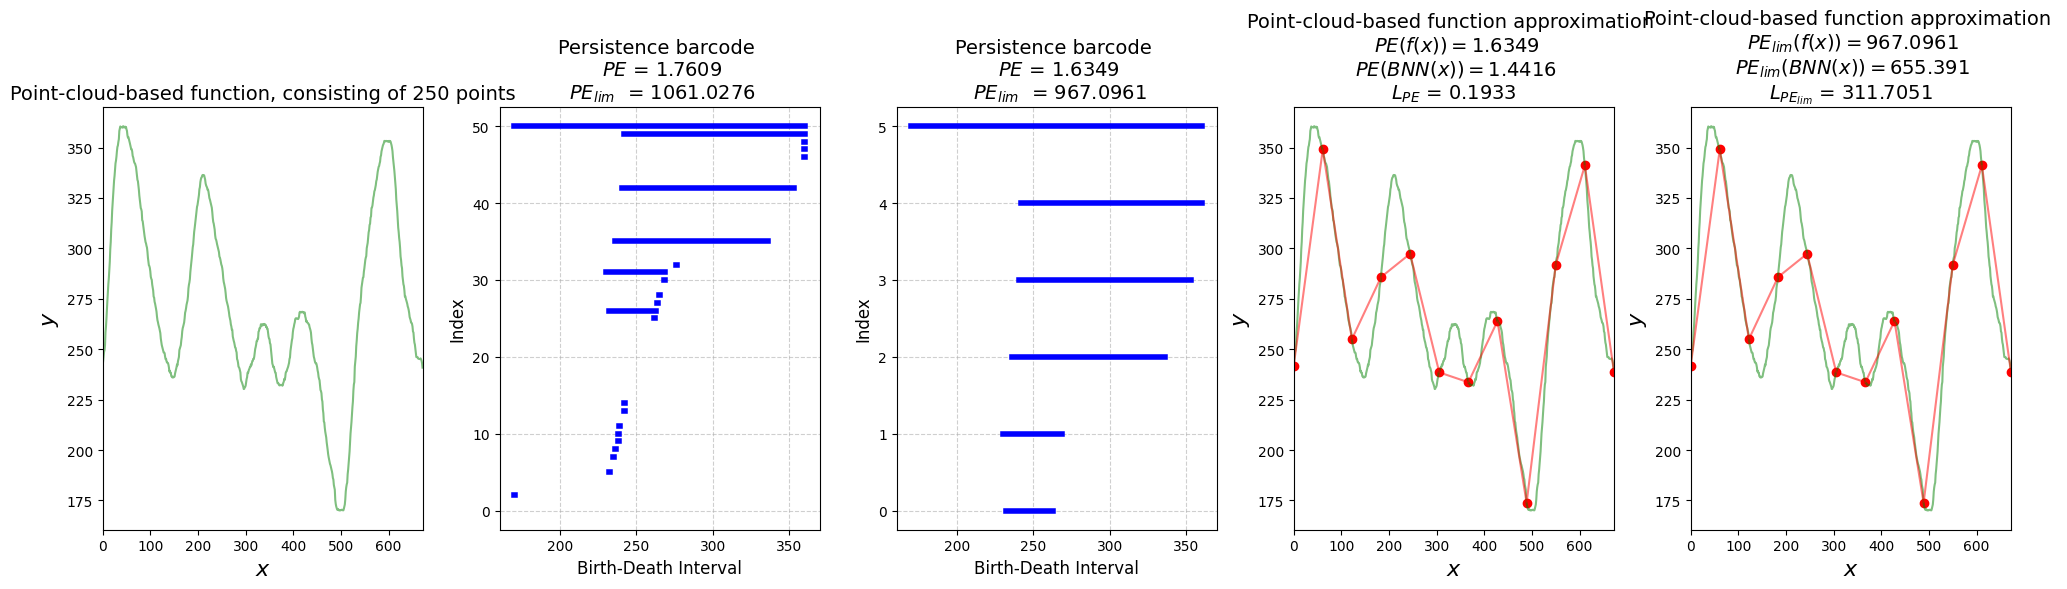

In [ ]:
df = pd.read_csv("noisepointcloud.csv",sep=",")
n_points = df.shape[0] 
np.random.seed(0)
x_train, y_train = np.arange(n_points), df["y"].values + np.random.normal(scale=0.2, size=n_points) 
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(n_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 10
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=dgmRefFilt.shape[0]*2-2
x_points = tf.Variable(tf.cast(tf.linspace(0,n_points,num_points_optimize+2), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricSigmaNetworkTf(points)

y_aprox = model(x_train)

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]

entropyAprox=persistent_entropy_tf(dgmAprox)
entropyAproxLim=persistent_entropy_lim_tf(dgmAprox)

loss = PersistentEntropyLossTF()
lossLim = PersistentEntropyLossLimTF()
error = loss(dgmRefFilt,dgmAprox)
errorLim = lossLim(dgmRefFilt,dgmAprox)

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((0,n_points))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyRef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefLim.numpy().item(),4)}")
plot_persistent_barcode(dgmRefFilt,ax=axs[2])
axs[2].set_title(axs[2].get_title() + f" \n $PE$ = {round(entropyRefFilt.numpy().item(),4)}")
axs[2].set_title(axs[2].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefFiltLim.numpy().item(),4)}")
axs[3].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[3].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[3].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$y$')
axs[3].set_xlim((0,n_points))
axs[3].set_title(f'Point-cloud-based function approximation \n $PE(f(x)) = {np.round(entropyRefFilt.numpy().item(),4)}$\n $PE(BNN(x)) = {np.round(entropyAprox.numpy().item(),4)}$ \n' + '$L_{PE}$' + f' = {round(error.numpy().item(),4)}')
axs[4].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[4].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[4].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[4].set_xlabel('$x$')
axs[4].set_ylabel('$y$')
axs[4].set_xlim((0,n_points))
axs[4].set_title(f'Point-cloud-based function approximation \n $PE_{{lim}}(f(x)) = {np.round(entropyRefFiltLim.numpy().item(),4)}$ \n $PE_{{lim}}(BNN(x)) = {np.round(entropyAproxLim.numpy().item(),4)}$ \n' + '$L_{PE_{lim}}$' + f' = {round(errorLim.numpy().item(),4)}')
fig.tight_layout()
plt.show()

## MSE loss

100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


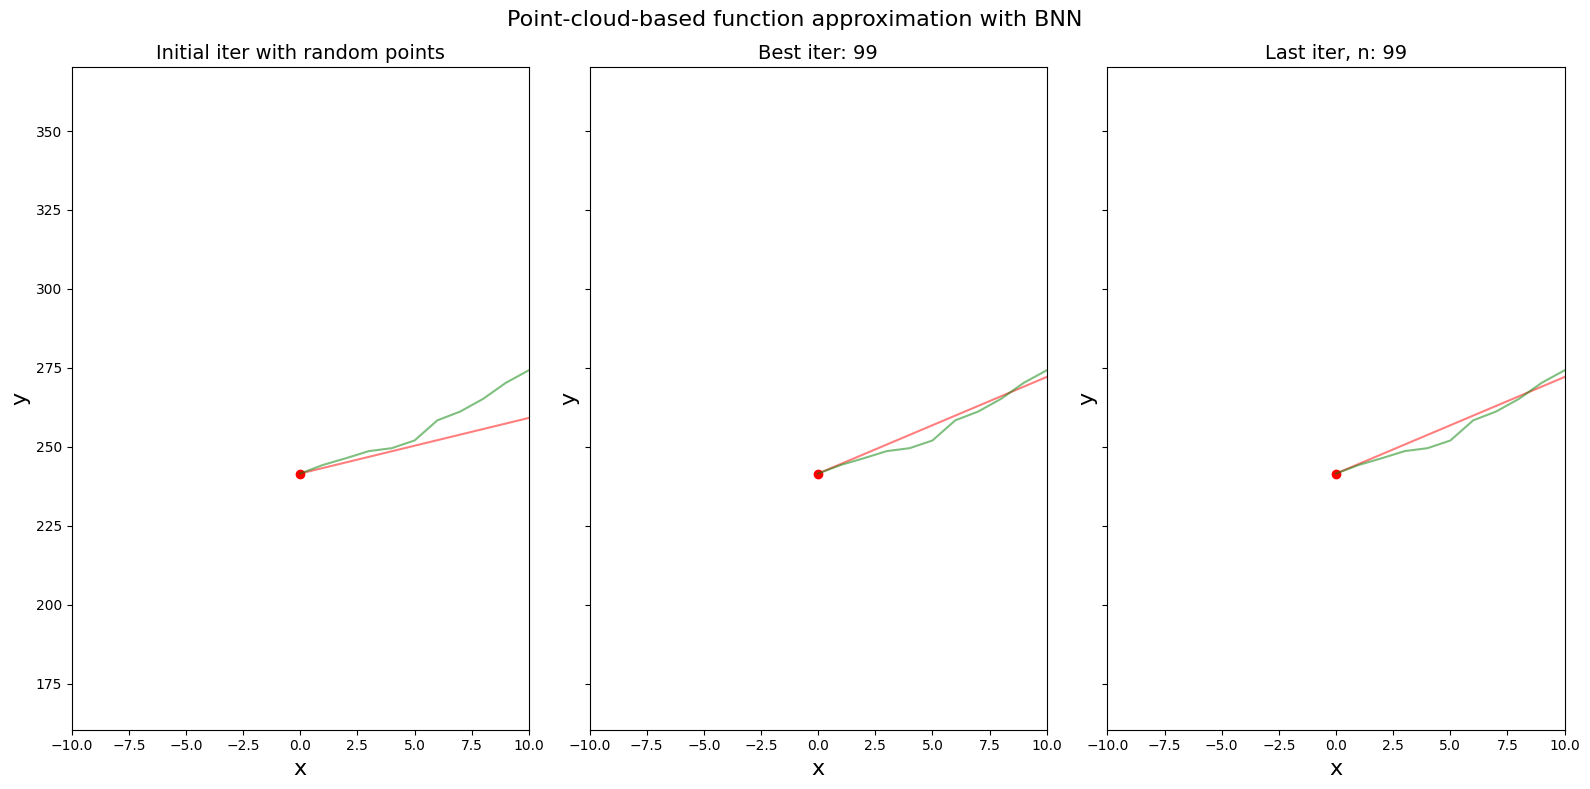

In [ ]:
df = pd.read_csv("noisepointcloud.csv",sep=",")
n_points = df.shape[0] 
np.random.seed(0)
x_train, y_train = np.arange(n_points), df["y"].values + np.random.normal(scale=0.2, size=n_points) 
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(n_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 10
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=dgmRefFilt.shape[0]*2-2
x_points = tf.Variable(tf.cast(tf.linspace(0,n_points,num_points_optimize+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    lossFunction = PersistentEntropyLossLimTF()
    entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasMSE_noise2 = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/RandomPointCloud_MSELoss.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

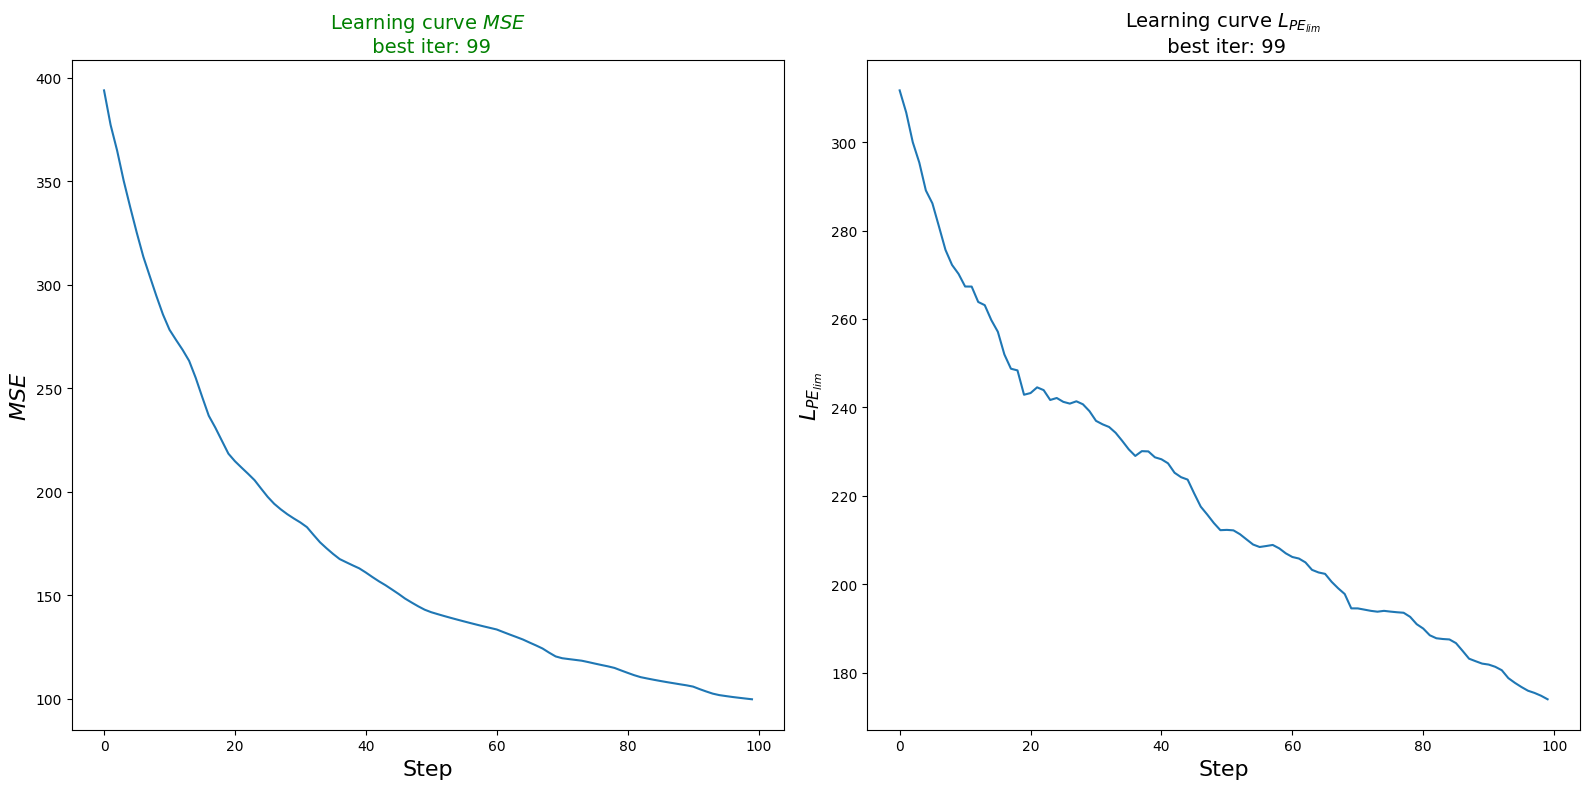

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## $L_{PE_{lim}}$ loss

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


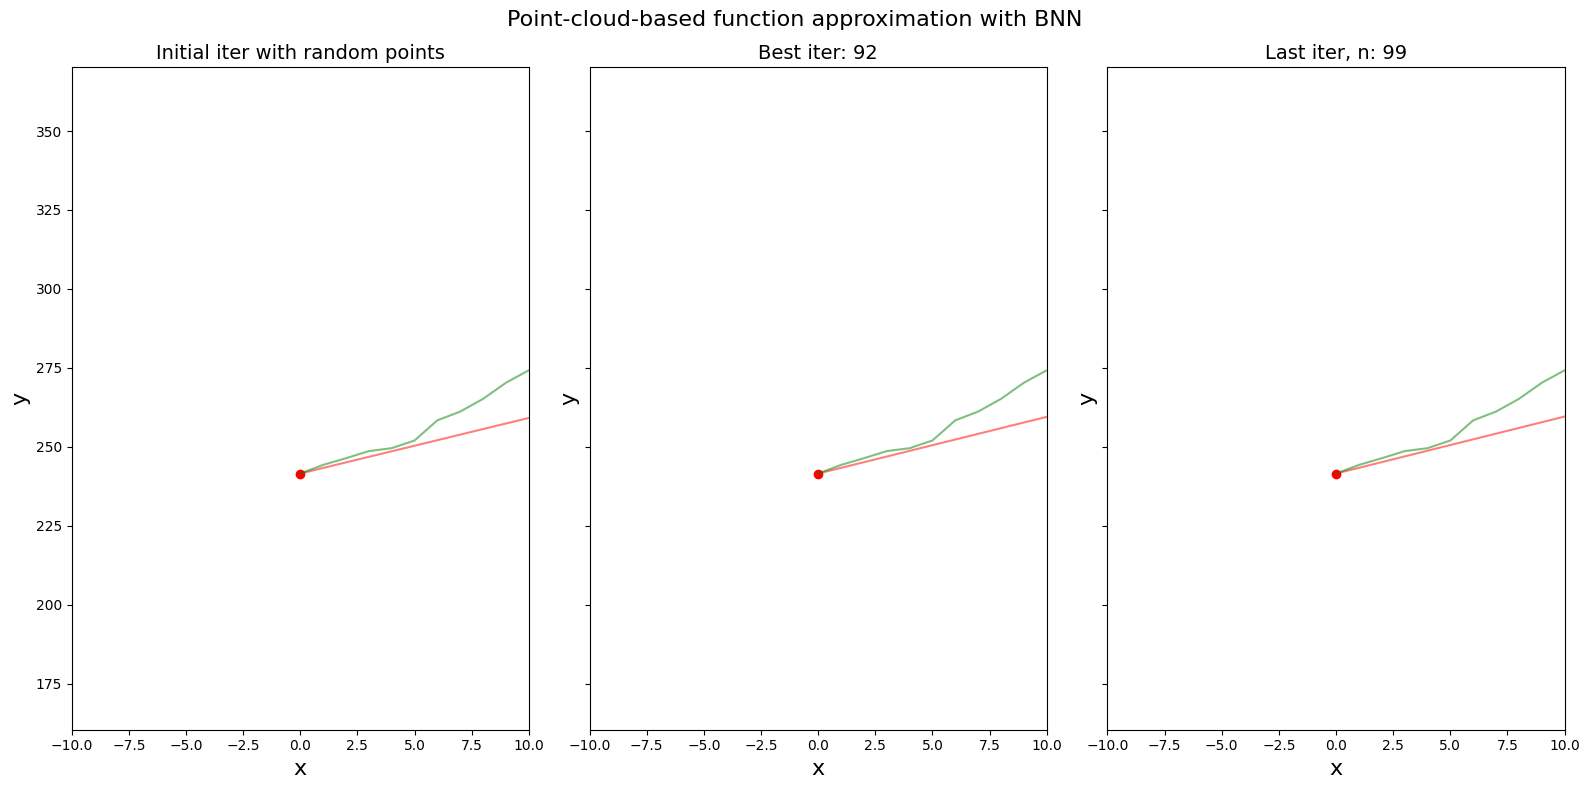

In [ ]:
df = pd.read_csv("noisepointcloud.csv",sep=",")
n_points = df.shape[0] 
np.random.seed(0)
x_train, y_train = np.arange(n_points), df["y"].values + np.random.normal(scale=0.2, size=n_points) 
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(n_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 10
dgmRefFilt = dgmRef[mask]
entropyRefFilt=persistent_entropy_tf(dgmRefFilt)
entropyRefFiltLim=persistent_entropy_lim_tf(dgmRefFilt)

num_points_optimize=dgmRefFilt.shape[0]*2-2
x_points = tf.Variable(tf.cast(tf.linspace(0,n_points,num_points_optimize+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_optimize + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_noise2  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/RandomPointCloud_PELoss.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

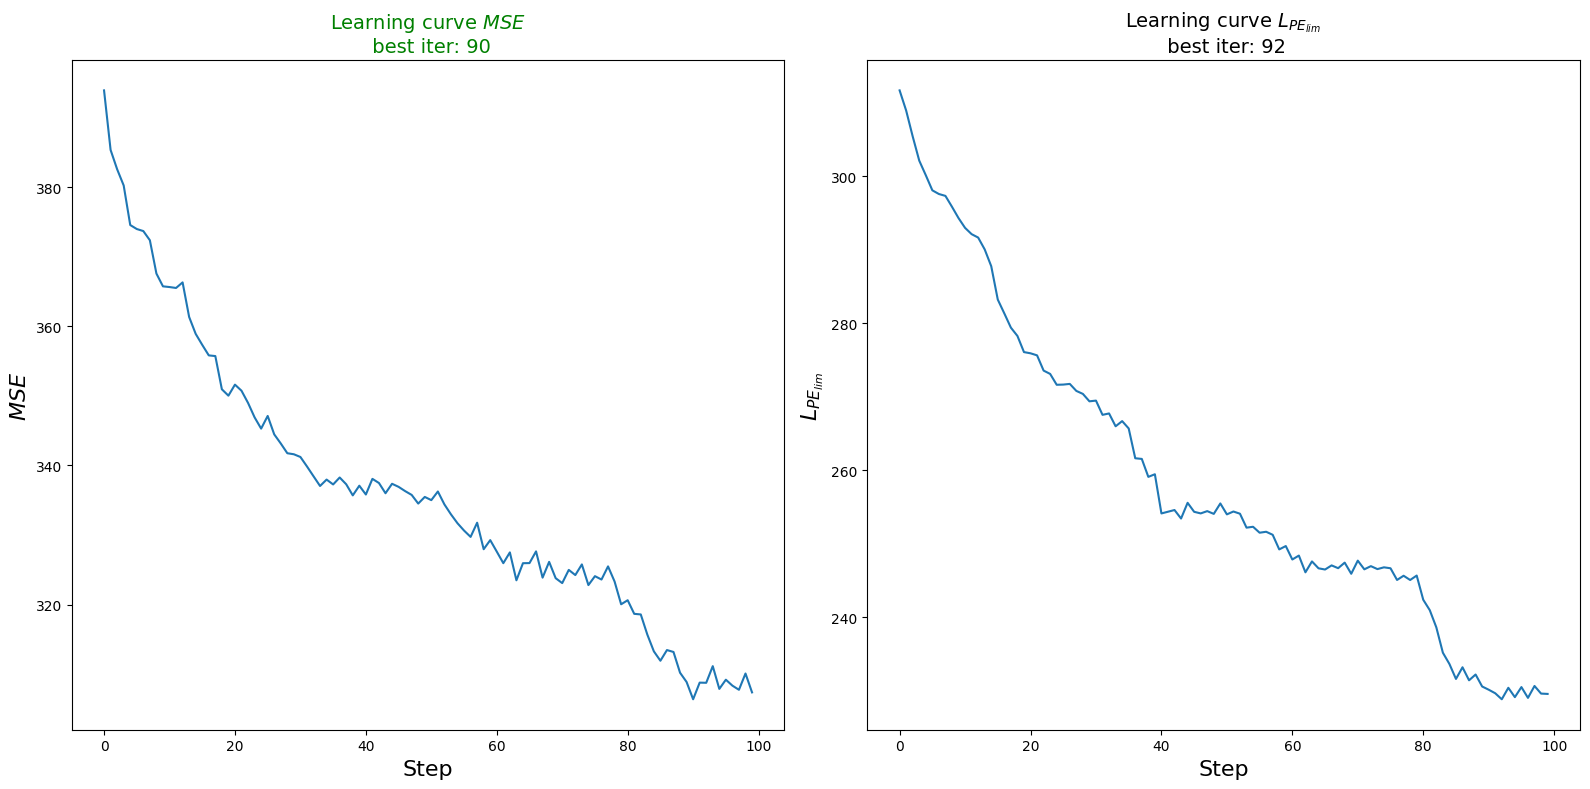

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## Comparing learning curves MSE and $L_{PE_{lim}}$

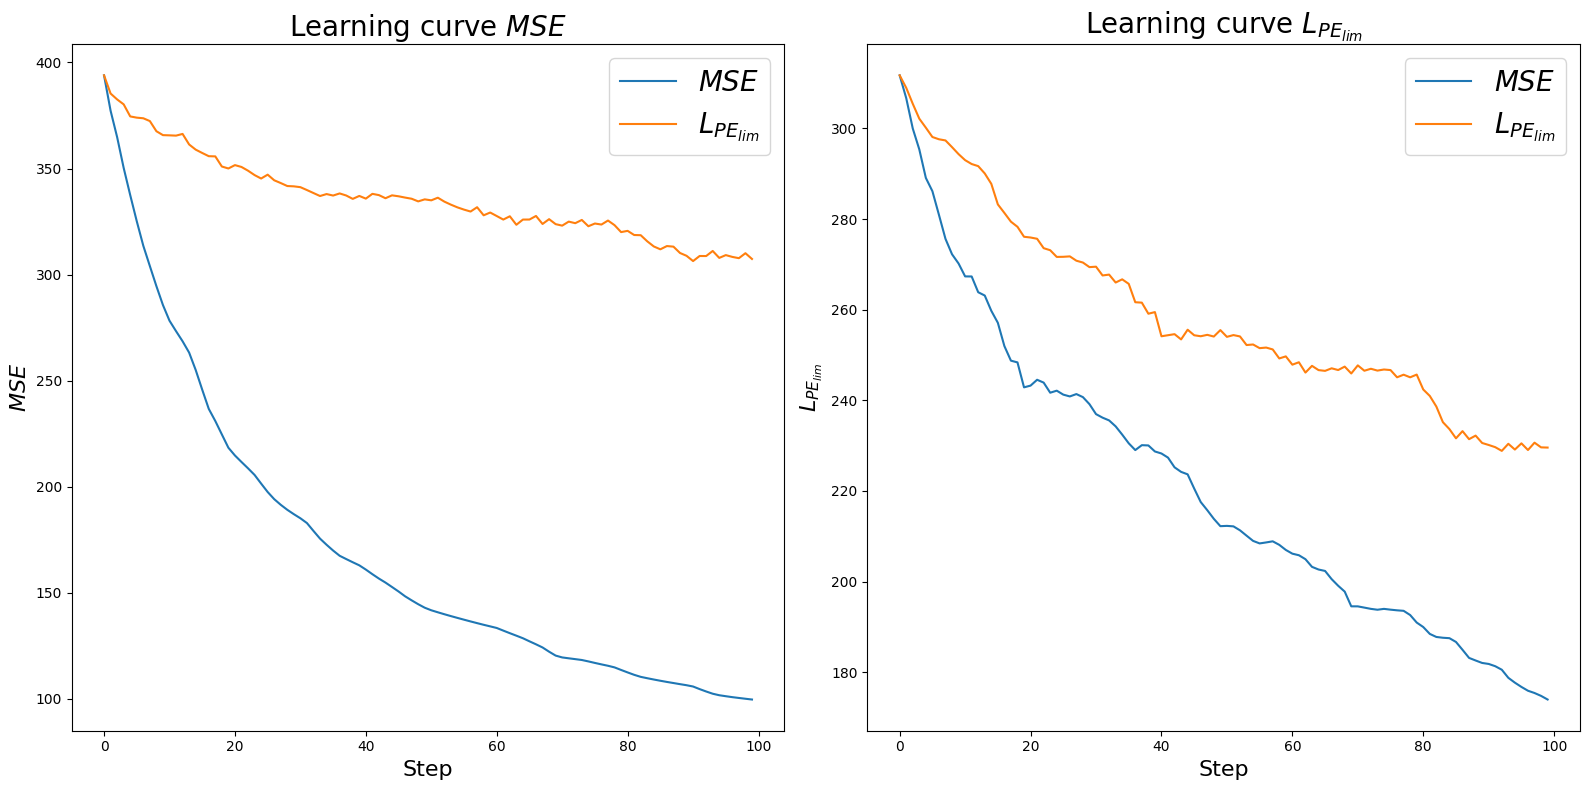

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{PE_{lim}}$"]
for i, metric in enumerate([metricasMSE_noise2, metricasPE_noise2]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_RandomPointCloud.png', dpi=300, bbox_inches='tight')
plt.show()